In [1]:
import pandas as pd

In [7]:
seci = pd.read_csv('../outputs/eci_software_2020_2023.csv',sep=';')
seci=seci[seci['year']==2021]

In [8]:
language_to_seci=dict(seci.groupby(['language'])['pci'].first())

In [9]:
gpt = pd.read_csv('../data/gpt_effect_estimates.csv',index_col=0)

In [10]:
map_names = {
    'vbscript':'VBScript',
    'objective-c':'Objective-C',
    'actionscript':'ActionScript',
    'gdb':'GDB',
    'tsql':'TSQL',
    'matlab':'MATLAB',
    'vb.net':'Visual Basic .NET',
    'php':'PHP',
    'coffeescript':'CoffeeScript',
    'asp.net':'ASP.NET',
    'qml':'QML',
    'vba':'VBA',
    'xslt':'XSLT',
    'applescript':'AppleScript',
    'cmake':'CMake',
    'vue.js':'Vue',
    'html':'HTML',
    'css':'CSS',
    'javascript':'JavaScript',
    'jupyter-notebook':'Jupyter Notebook',
    'powershell':'PowerShell',
    'typescript':'TypeScript'  
}

In [11]:
clean = {}
for x in gpt.index:
    if x.capitalize() in language_to_seci:
        clean[x]=x.capitalize()
    elif x in map_names:
        clean[x]=map_names[x]
    else:
        print(x)
  

delphi
coldfusion
arduino
hive
click
cucumber
max
gradle
sas
sed
io
nginx
sql
plsql


In [12]:
gpt.index=gpt.index.map(lambda x: clean.get(x,'missing'))
gpt_effect=dict(gpt[gpt.index!='missing'].estimate)

In [21]:
seci

,iso2_code,language,num_pushers,period,diversity,ubiquity,mcp,eci,pci,density,coi,cog,rca,year
20433,AE,ANTLR,0,1,20,19,0,-0.309502,2.266022,0.041579,-0.155929,1.215156,0.0,2021
20434,AE,ASP.NET,0,1,20,38,0,-0.309502,0.245440,0.217603,-0.155929,0.211059,0.0,2021
20435,AE,Ada,0,1,20,9,0,-0.309502,2.349027,0.025539,-0.155929,1.057385,0.0,2021
20436,AE,Apex,0,1,20,7,0,-0.309502,2.080937,0.028616,-0.155929,0.957892,0.0,2021
20437,AE,AppleScript,0,1,20,11,0,-0.309502,2.511345,0.025733,-0.155929,1.266366,0.0,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42474,ZW,Vue,0,1,9,59,0,-0.728048,-0.506694,0.153719,-0.735638,-0.206616,0.0,2021
42475,ZW,XS,0,1,9,13,0,-0.728048,2.062189,0.012541,-0.735638,1.013624,0.0,2021
42476,ZW,XSLT,0,1,9,30,0,-0.728048,1.954708,0.021310,-0.735638,0.963811,0.0,2021
42477,ZW,Yacc,0,1,9,29,0,-0.728048,2.098227,0.018802,-0.735638,1.041352,0.0,2021


In [29]:
seci2=seci.groupby(['language'])['ubiquity'].first().reset_index()
seci2['gpt_effect']=seci2['language'].map(gpt_effect)
seci2=seci2[~seci2['gpt_effect'].isnull()]
seci2['ubiquity']=seci2['ubiquity'].map(np.log)

In [30]:
seci2['gpt_effect']=1-seci2['gpt_effect']

In [31]:
seci2['pci_binned'] = pd.cut(seci2['ubiquity'], bins=3, labels=False)


R^2: -16.10
p:0.00038627144689053845
0.4698136892164404


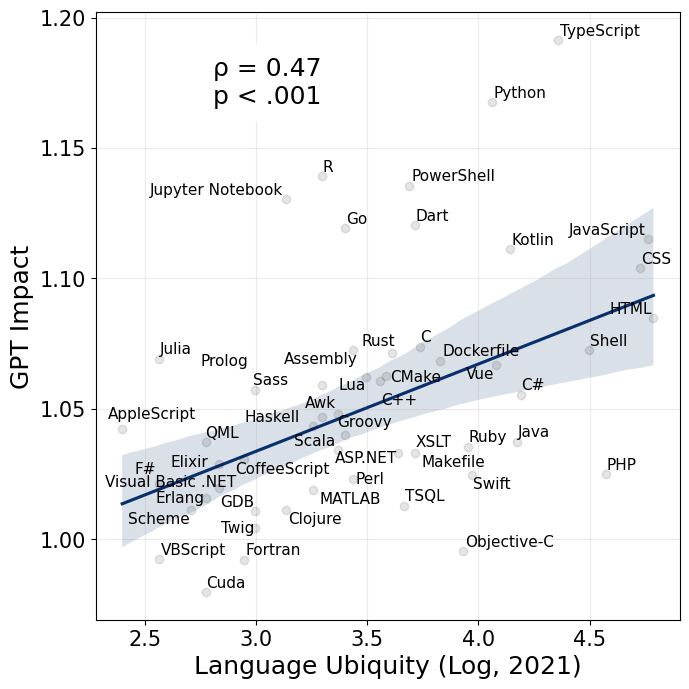

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns
from adjustText import adjust_text

plt.figure(figsize=(7,7))

# Plot the scatter plot with error bars
plt.errorbar(seci2['ubiquity'],seci2['gpt_effect'], yerr=0, fmt='o', capsize=0, label='Observations',
            color='black',alpha=.1)

# Fit a line to the data
model = LinearRegression()
model.fit(seci2[['ubiquity']], seci2['gpt_effect'])

# Get the line's y values
seci2['y_fit'] = model.predict(seci2[['ubiquity']])

# Plot the line
sns.regplot(x='ubiquity', y='gpt_effect', data=seci2,robust=True,#lowess=True,
            ci=95, line_kws={'color': '#08306b', 'label':'Fit'}, scatter=False)

#plt.plot(df2['log_nrepos_2021'], df2['y_fit'], color='red', label='Fit')

texts= []
for i, row in seci2.iterrows():
    texts.append(plt.annotate(row['language'], (row['ubiquity'], row['gpt_effect']),size=11))
#    plt.annotate(row['index'], (row['log_nrepos_2021'], row['estimate']),size=8)
adjust_text(texts)

# Report R squared
r2 = r2_score(seci2['ubiquity'], seci2['gpt_effect'])
print(f'R^2: {r2:.2f}')

pearson_corr, p_value = stats.pearsonr(seci2['ubiquity'], seci2['gpt_effect'])
print('p:'+str(p_value))
print(pearson_corr)
plt.annotate(f'ρ = {pearson_corr:.2f}\np < .001',
             xy=(.2,.85), xycoords='axes fraction',size=18,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=.5'))

plt.xlabel('Language Ubiquity (Log, 2021)',size=18)
plt.ylabel('GPT Impact',size=18)
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid(alpha=.25)
# Show the plot
plt.tight_layout()
plt.savefig('../outputs/tag_effects_vs_github_repos.pdf')
plt.show()


In [33]:
seci2.corr()

/var/folders/gf/x21_n30n2l13jz3jhcfzjc_40000gn/T/ipykernel_88185/3647832695.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  seci2.corr()


,ubiquity,gpt_effect,pci_binned,y_fit
ubiquity,1.000000,0.469814,0.926518,1.000000
gpt_effect,0.469814,1.000000,0.522081,0.469814
pci_binned,0.926518,0.522081,1.000000,0.926518
y_fit,1.000000,0.469814,0.926518,1.000000
